### Data Preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Reading ratings file
# Ignore the timestamp column
ratings = pd.read_csv('ratings.csv', encoding='UTF-8', usecols=['userId', 'movieId', 'rating', 'timestamp'])

# Reading users file
tags = pd.read_csv('tags.csv', encoding='UTF-8', usecols=['userId', 'movieId', 'tag', 'timestamp'])

# Reading movies file
movies = pd.read_csv('movies.csv', encoding='UTF-8', usecols=['movieId', 'title', 'genres'])

In [2]:
# Check the top 5 rows
ratings.head()


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [3]:
# Check the file info
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
userId       100836 non-null int64
movieId      100836 non-null int64
rating       100836 non-null float64
timestamp    100836 non-null int64
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [4]:
# Check the top 5 rows
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [5]:
# Check the file info
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
userId       3683 non-null int64
movieId      3683 non-null int64
tag          3683 non-null object
timestamp    3683 non-null int64
dtypes: int64(3), object(1)
memory usage: 100.7+ KB


In [6]:
# Check the top 5 rows
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [7]:
# Check the file info
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
movieId    9742 non-null int64
title      9742 non-null object
genres     9742 non-null object
dtypes: int64(1), object(2)
memory usage: 152.3+ KB


### Data Exploration¶

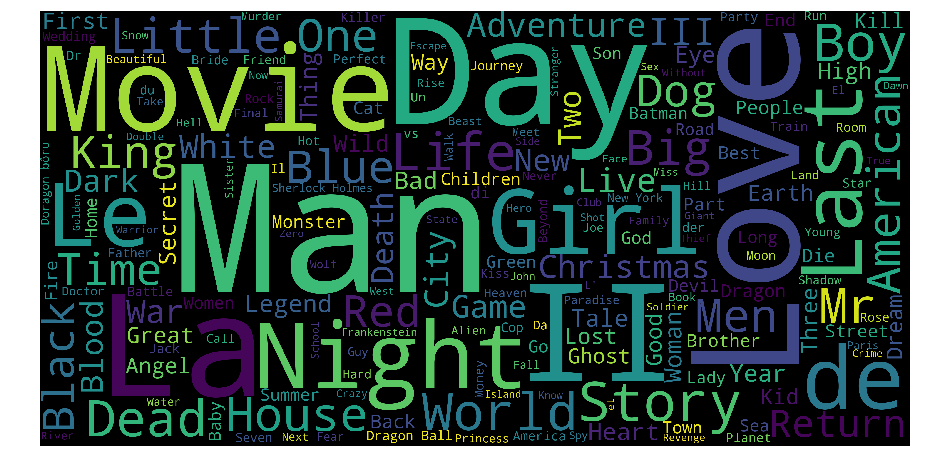

In [8]:
# Import new libraries
%matplotlib inline
import wordcloud
from wordcloud import WordCloud, STOPWORDS

# Create a wordcloud of the movie titles
movies['title'] = movies['title'].fillna("").astype('str')
title_corpus = ' '.join(movies['title'])
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', height=2000, width=4000).generate(title_corpus)

# Plot the wordcloud
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

In [9]:
# Get summary statistics of rating
ratings['rating'].describe()

count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

/home/jarvis/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


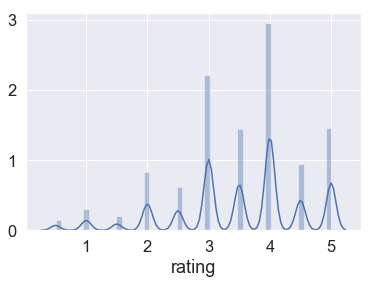

In [10]:
# Import seaborn library
import seaborn as sns
sns.set_style('whitegrid')
sns.set(font_scale=1.5)
%matplotlib inline

# Display distribution of rating
sns.distplot(ratings['rating'].fillna(ratings['rating'].median()))

In [13]:
# Join 2 files into one dataframe
dataset = pd.merge(movies, ratings) 

# Display 20 movies with highest ratings
ds = dataset.sort_values('rating', ascending=False)

ds.head()

,movieId,title,genres,userId,rating,timestamp
56251,3676,Eraserhead (1977),Drama|Horror,567,5.0,1525282299
33888,1639,Chasing Amy (1997),Comedy|Drama|Romance,147,5.0,1203267694
20742,914,My Fair Lady (1964),Comedy|Drama|Musical|Romance,188,5.0,962560181
10168,356,Forrest Gump (1994),Comedy|Drama|Romance|War,283,5.0,901228020
10169,356,Forrest Gump (1994),Comedy|Drama|Romance|War,284,5.0,832695327


In [14]:
# Make a census of the genre keywords
genre_labels = set()
for s in movies['genres'].str.split('|').values:
    genre_labels = genre_labels.union(set(s))

# Function that counts the number of times each of the genre keywords appear
def count_word(dataset, ref_col, census):
    keyword_count = dict()
    for s in census: 
        keyword_count[s] = 0
    for census_keywords in dataset[ref_col].str.split('|'):        
        if type(census_keywords) == float and pd.isnull(census_keywords): 
            continue        
        for s in [s for s in census_keywords if s in census]: 
            if pd.notnull(s): 
                keyword_count[s] += 1
    #______________________________________________________________________
    # convert the dictionary in a list to sort the keywords by frequency
    keyword_occurences = []
    for k,v in keyword_count.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurences, keyword_count

# Calling this function gives access to a list of genre keywords which are sorted by decreasing frequency
keyword_occurences, dum = count_word(movies, 'genres', genre_labels)
keyword_occurences[:5]

[['Drama', 4361],
 ['Comedy', 3756],
 ['Thriller', 1894],
 ['Action', 1828],
 ['Romance', 1596]]

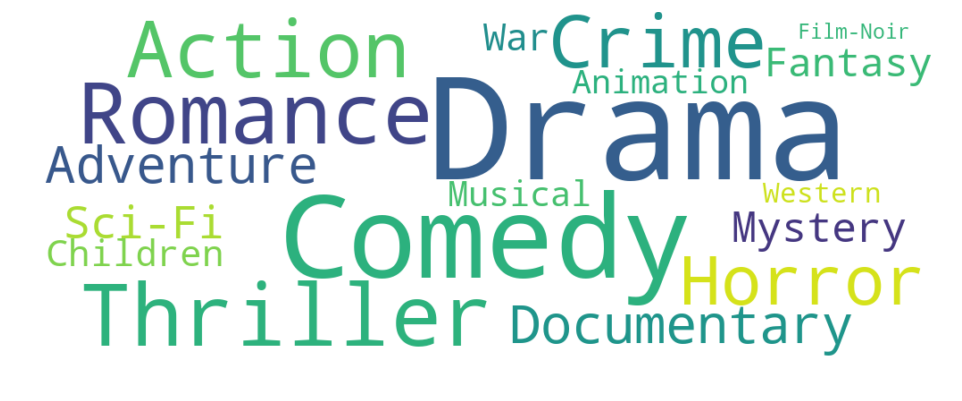

In [48]:
# Define the dictionary used to produce the genre wordcloud
genres = dict()
trunc_occurences = keyword_occurences[0:18]
for s in trunc_occurences:
    genres[s[0]] = s[1]

# Create the wordcloud
genre_wordcloud = WordCloud(width=1000,height=400, background_color='white')
genre_wordcloud.generate_from_frequencies(genres)

# Plot the wordcloud
f, ax = plt.subplots(figsize=(16, 8))
plt.imshow(genre_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

## Implementation

Content-Based Recommendation Engine that computes similarity between movies based on movie genres. 
It will suggest movies that are most similar to a particular movie based on its genre.

In [15]:
# Break up the big genre string into a string array
movies['genres'] = movies['genres'].str.split('|')
# Convert genres to string value
movies['genres'] = movies['genres'].fillna("").astype('str')

TfidfVectorizer function from scikit-learn, which transforms text to feature vectors that can be used as input to estimator.

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(movies['genres'])
tfidf_matrix.shape

(9742, 177)

In [17]:
from sklearn.metrics.pairwise import linear_kernel
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
cosine_sim[:4, :4]

array([[1.        , 0.31379419, 0.0611029 , 0.05271111],
       [0.31379419, 1.        , 0.        , 0.        ],
       [0.0611029 , 0.        , 1.        , 0.35172407],
       [0.05271111, 0.        , 0.35172407, 1.        ]])

In [18]:
# Build a 1-dimensional array with movie titles
titles = movies['title']
indices = pd.Series(movies.index, index=movies['title'])

# Function that get movie recommendations based on the cosine similarity score of movie genres
def genre_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:21]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

In [26]:
genre_recommendations('Hulk (2003)').head(20)

224             Star Wars: Episode IV - A New Hope (1977)
275                                       Stargate (1994)
385                                 Demolition Man (1993)
898     Star Wars: Episode V - The Empire Strikes Back...
911     Star Wars: Episode VI - Return of the Jedi (1983)
1058           Star Trek III: The Search for Spock (1984)
1346                                 Lost in Space (1998)
1557                                Rocketeer, The (1991)
1567                                          Tron (1982)
1692                            Six-String Samurai (1998)
1904                                   Logan's Run (1976)
1979     Star Wars: Episode I - The Phantom Menace (1999)
1986                                      Superman (1978)
1988                                  Superman III (1983)
1989              Superman IV: The Quest for Peace (1987)
2764                                       Mad Max (1979)
2766                    Mad Max Beyond Thunderdome (1985)
2836          

In [28]:
genre_recommendations('Lion King, The (1994)').head(20)

1273                                     Anastasia (1997)
786                                          Dumbo (1941)
7915                                  Rock of Ages (2012)
2381                                 Fantasia 2000 (1999)
1597                           Secret of NIMH, The (1982)
2016                                        Tarzan (1999)
7039                                            Up (2009)
44                                      Pocahontas (1995)
618                   Hunchback of Notre Dame, The (1996)
3896                                          1776 (1972)
1596                                Watership Down (1978)
2106        Little Nemo: Adventures in Slumberland (1992)
5546    Kiki's Delivery Service (Majo no takkyûbin) (1...
790                         Fox and the Hound, The (1981)
1493                                         Bambi (1942)
6405                                   Ratatouille (2007)
1390                                         Mulan (1998)
12            